# Traveling Salesman Problem: Genetic Algorithm

This is an implementation of a genetic algorithm to find an approximate solution to any TSP problem. I use a Map class which is essentially just a dictionary of coordinates for each city with a few useful functions. The bulk of the work is in the Population class which creates a group of random possible routes and then can iterate through generations by breeding its shortest routes.

In [2]:
import numpy as np 
import random, operator, math
import pandas as pd 
import matplotlib.pyplot as plt 

In [3]:

# this function was taken from https://www.tutorialexample.com/python-matplotlib-implement-a-scatter-plot-with-labels-a-completed-guide-matplotlib-tutorial/
def plot_with_labels(coord, labels):
    assert len(coord) == len(labels), 'coord len is not equal to labels len'
    plt.figure(figsize=(5, 5))  # in inches
    for i, label in enumerate(labels): #get (0, label)
        x, y = coord[i] #2 dim
        plt.scatter(x, y)
                #
        plt.annotate(label,
                xy=(x, y), #show point 
                xytext=(5, 2), #show annotate
                textcoords='offset points',
                ha='right',
                va='bottom')

# this map object is mostly a wrapper for a dictionary where each entry
# is a city and each value is a pair of coordinates
class Map:

    # in initialization it randomly assigns coordinates to the number of
    # cities given by the user
    def __init__(self,n_cities):
        self.cities = {}
        for i in range(0,n_cities):
            self.cities[i] = [round(random.random() * 1000, 2), round(random.random() * 1000, 2)]
    
    # this returns the distance between any two cities
    def distance(self,city1, city2):
        xDis = self.cities[city1][0] - self.cities[city2][0]
        yDis = self.cities[city1][1] - self.cities[city2][1]
        return round(math.sqrt(xDis ** 2 + yDis ** 2), 2)

    # this returns a plot of the cities to show their spatial relations
    def plot(self):
        coords = np.array(list(self.cities.values()))
        return plot_with_labels(coords, self.cities.keys())

    # this prints the dictionary of cities
    def display(self):
        print(self.cities)

# this function creates a random legal route for the given map
def gen_route(map):
    route = list(range(1,len(map.cities)))
    random.shuffle(route)
    route.insert(0,0)
    return route

# this function calculates the total distance of a route
def route_distance(route, map):
    dist = 0
    for i in range(0,len(route) - 1):
        dist += map.distance(route[i],route[i+1])
    dist += map.distance(route[len(route)-1],route[0])
    return dist


# this population object is a group of routes for any map of a given size
# each route is a list of cities that will change over generations
class Population:

    # in initialization the population creates the number of random routes
    # specified by the user
    def __init__(self, popsize, map):
        self.routes = []
        for i in range(0,popsize):
            self.routes.append(gen_route(map))
        self.generation = 0
        
    # this prints the list of routes
    def display(self):
        print(self.routes)

    # this returns the average total distance of each route
    def avg_distance(self,map):
        avg = 0
        for i in range(0,len(self.routes)):
            avg += route_distance(self.routes[i], map)
        avg = avg / len(self.routes)
        return round(avg, 2)

    # this finds the top routes based on total distance traveled
    def top_routes(self,perc,map):
        
        dists = []
        for i in range(0,len(self.routes)):
            dists.append([i,route_distance(self.routes[i], map)])

        dists = np.array(sorted(dists,key=lambda x: x[1]))
        stop_index = round(perc * len(self.routes))
        
        top = []
        for i in range(0,stop_index):
            top.append(self.routes[int(dists[i,0])])
        
        return top

    # this updates the population's routes by randomly breeding from the
    # top routes of the population. The next generation includes all of the top
    # routes and enough children to maintain the population size
    def next_gen(self,perc,mut_rate,n_mut,map):

        top = self.top_routes(perc,map)
        new_routes = top

        for i in range(len(top), len(self.routes)):
            parent1 = random.choice(top)
            parent2 = random.choice(top)
            new_routes.append(self.breed(parent1, parent2, mut_rate, n_mut))
        
        self.routes = new_routes

    # this function breeds two parent routes by randomly selecting 
    # cities for each index in the route list. If neither parent has
    # a city (in a given index) that the child hasn't visited yet then
    # a random, unvisited city is selected. Then there is a 20% chance that 
    # a random pair of cities will be swapped. 
    def breed(self,parent1,parent2,mut_rate,n_mut):
        child = [0]
        for i in range(1, len(parent1)):
                gene = round(random.random() + 1)
                
                if gene == 1 and not(parent1[i] in child):
                    child.append(parent1[i])
                elif gene == 2 and not(parent2[i] in child):
                    child.append(parent2[i])
                else: 
                    mutations = list(filter(lambda x: not x in child, range(0,len(parent1))))
                    child.append(random.choice(mutations))

        for i in range(0,n_mut):
            if random.random() < mut_rate:
                g1, g2 = random.sample(range(1,len(child)), 2)
                child[g1], child[g2] = child[g2], child[g1]
        
        return child

def generate_solution(map, popsize, generations, elite_prop, mut_rate, n_mut, plot = False):
    population = Population(popsize, map)
    avg_progress = []
    top_progress = []
    for i in range(0,generations):
        population.next_gen(elite_prop, mut_rate, n_mut, map)
        avg_progress.append(population.avg_distance(map))
        top_progress.append(route_distance(population.top_routes(elite_prop, map)[0],map))
    
    if plot:
        plt.plot(avg_progress, color = "blue", label = "average")
        plt.plot(top_progress, color = "orange", label = "best")
        plt.ylabel('Distance')
        plt.xlabel('Generation')
        plt.legend()
        plt.show()

    return population.top_routes(elite_prop, map)[0]


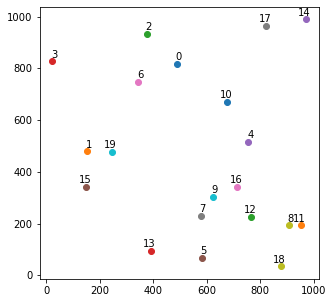

In [16]:
# this generates and plots a map
map = Map(20)
map.plot()

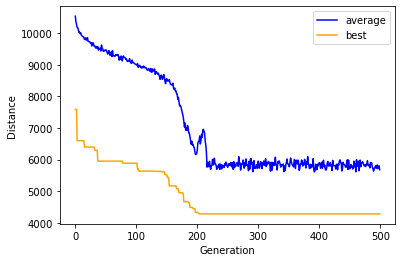

4279.89
[0, 17, 14, 10, 4, 16, 9, 12, 8, 11, 18, 5, 7, 13, 15, 19, 1, 3, 6, 2]


In [21]:
# this generates a solution with the given parameters
solution = generate_solution(map, 
                             popsize = 1000, 
                             generations = 500, 
                             elite_prop = .2, 
                             mut_rate = .2, 
                             n_mut = 3, 
                             plot = True)

print(route_distance(solution,map))
print(solution)

In [22]:
# this is the best solution I could find by hand
best = [0, 17, 14, 10, 4, 11, 8, 18, 12, 16, 9, 7, 5, 13, 15, 19, 1, 3, 6, 2]
route_distance(best, map)

4258.93